# Homework 3

- Implement the ridge regression algorithm through a gradient descent algorithm (remember you need a properly chosen learning rate)
- apply it to a regression problem (with at least 10 predictors) for a chosen dataset
- optimize the choice of lambda with R^2 and cross-validation 
- check the accuracy of the final prediction on the test part of the data set.
- compare to a result of a simple linear regression fit
- comment on the results

### author: Maria Lewandowska
### source: https://www.kaggle.com/dipam7/student-grade-prediction

## About the dataset:

This data approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por). In [Cortez and Silva, 2008], the two datasets were modeled under binary/five-level classification and regression tasks. Important note: the target attribute G3 has a strong correlation with attributes G2 and G1. This occurs because G3 is the final year grade (issued at the 3rd period), while G1 and G2 correspond to the 1st and 2nd period grades. It is more difficult to predict G3 without G2 and G1, but such prediction is much more useful (see paper source for more details).

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize']=12,10
import seaborn as sns

import itertools as it
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')


from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg

import sklearn.preprocessing as Preprocessing

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import itertools as it
from itertools import combinations

import scipy as sp

np.random.seed(17)

In [2]:
data = pd.read_csv('student.csv')
data.dropna()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
5,GP,M,16,U,LE3,T,4,3,services,other,...,5,4,2,1,2,5,10,15,15,15
6,GP,M,16,U,LE3,T,2,2,other,other,...,4,4,4,1,1,3,0,12,12,11
7,GP,F,17,U,GT3,A,4,4,other,teacher,...,4,1,4,1,1,1,6,6,5,6
8,GP,M,15,U,LE3,A,3,2,services,other,...,4,2,2,1,1,1,0,16,18,19
9,GP,M,15,U,GT3,T,3,4,other,other,...,5,5,1,1,1,5,0,14,15,15


In [3]:
#data.info()

In [4]:
data['Medu'] = data['Medu'].astype(object)
data['Fedu'] = data['Fedu'].astype(object)

# Some of the predictors are categorical. Lets produce some dummy variables
categorical_bolean = (data.dtypes == "object").values
data_numeric = data.loc[:, ~categorical_bolean]
data_categorical = data.loc[:, categorical_bolean]
data_dummies = pd.get_dummies(data_categorical)

data = pd.concat([data_numeric, data_dummies], axis=1)
data.head()

,age,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,2,2,0,4,3,4,1,1,3,...,1,0,0,1,0,1,1,0,1,0
1,17,1,2,0,5,3,3,1,1,3,...,1,0,1,0,0,1,0,1,1,0
2,15,1,2,3,4,3,2,2,3,3,...,1,0,0,1,0,1,0,1,1,0
3,15,1,3,0,3,2,2,1,1,5,...,0,1,0,1,0,1,0,1,0,1
4,16,1,2,0,4,3,2,1,2,5,...,1,0,0,1,0,1,1,0,1,0


## Correlation Matrix

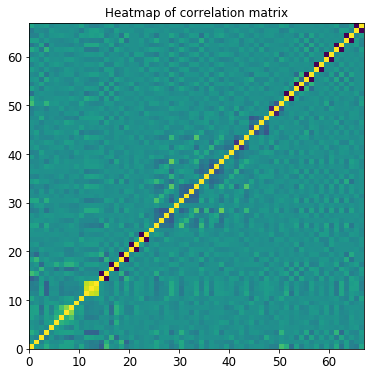

In [5]:
corr_matrix = np.corrcoef(data.T)
pd.DataFrame(corr_matrix)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.pcolor(corr_matrix)
ax.set_title('Heatmap of correlation matrix')

plt.show()

## Ridge Regression

In [6]:
x = data.drop( columns = ['G3'])
y = data['G3']

In [7]:
x_train, x_test = train_test_split(x, test_size = 0.25)

## Split the variables
y_train = y.iloc[x_train.index.values]
y_test = y.iloc[x_test.index.values]
x_train = x.iloc[x_train.index.values, :]
x_test = x.iloc[x_test.index.values, :]

## Transform to numpy 
y_train = y_train.values
y_test = y_test.values
x_train = x_train.values
x_test = x_test.values

In [8]:
# Ridge regression: Fit and evaluate 
alpha = 1.0
precission = 0.00001
coeff = []

reg = Ridge_Reg(alpha = alpha, solver = 'sag', tol = precission)
reg.fit(x_train, y_train)
coefficients = reg.coef_
coeff.append(coefficients)

predictors = [i for i, item in enumerate(coefficients) if abs(item) > 0]

print('Ridge: alpha = {:}'.format(alpha))
print('\nCoefficients: {:}'.format(coefficients))
print('\nSelected predictors:{:}'.format(predictors))
print('\nRidge Regression: R^2 score on training set:\t{:}'.format(reg.score(x_train,y_train)))
print('Ridge Regression: R^2 score on test set:\t{:}'.format(reg.score(x_test,y_test)))
print('\nAverage Cross Validation in training set:\t{:}'.format(np.average(cross_val_score(reg,x_train, y_train, scoring ='r2',cv = 5))))
print('Average Cross Validation in test set:\t{:}'.format(np.average(cross_val_score(reg,x_test, y_test, scoring ='r2',cv = 5))))


Ridge: alpha = 1.0

Coefficients: [-0.27670707  0.05440586 -0.15140791 -0.03643062  0.43102537  0.00647023
  0.13337673 -0.00233442  0.06762331  0.016387    0.05186108  0.19727557
  0.96195685 -0.13993746  0.13993746  0.03205899 -0.03205899 -0.13551333
  0.13551333 -0.15117918  0.15117918  0.08694168 -0.08694168  0.43240127
  0.30898357 -0.39325251 -0.20954684 -0.13858548  0.09677336  0.16009505
 -0.36421221  0.30918726 -0.20184345 -0.15084074  0.04463655 -0.00440189
  0.10183663  0.00876944 -0.16433677  0.2197516   0.13103307 -0.21638927
  0.02994137 -0.14193836 -0.24074447  0.33396877  0.04871407 -0.19934151
  0.07315876  0.12618275 -0.14177077  0.14177077  0.03695806 -0.03695806
  0.00917378 -0.00917378  0.07699557 -0.07699557  0.2276298  -0.2276298
 -0.26679142  0.26679142  0.31699519 -0.31699519  0.03567434 -0.03567434]

Selected predictors:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,

In [9]:
# Ridge regression: Fit and evaluate 
alpha = 10**2.2
precission = 0.00001

reg = Ridge_Reg(alpha = alpha, solver = 'sag', tol = precission)
reg.fit(x_train, y_train)
coefficients = reg.coef_
coeff.append(coefficients)

predictors = [i for i, item in enumerate(coefficients) if abs(item) > 0]

print('Ridge: alpha = {:}'.format(alpha))
print('\nCoefficients: {:}'.format(coefficients))
print('\nSelected predictors:{:}'.format(predictors))
print('\nRidge Regression: R^2 score on training set:\t{:}'.format(reg.score(x_train,y_train)))
print('Ridge Regression: R^2 score on test set:\t{:}'.format(reg.score(x_test,y_test)))
print('\nAverage Cross Validation in training set:\t{:}'.format(np.average(cross_val_score(reg,x_train, y_train, scoring ='r2',cv = 5))))
print('Average Cross Validation in test set:\t{:}'.format(np.average(cross_val_score(reg,x_test, y_test, scoring ='r2',cv = 5))))


Ridge: alpha = 158.48931924611142

Coefficients: [-1.79469198e-01  2.91491057e-02 -9.27273018e-02 -3.54763903e-02
  2.37209056e-01  1.16462965e-02  8.08517963e-02 -1.30327318e-02
  5.44960383e-02  2.55992190e-02  4.28168273e-02  2.68761528e-01
  8.61310792e-01 -3.42411010e-02  3.42411010e-02  3.58953894e-03
 -3.58953894e-03 -3.42139138e-02  3.42139138e-02 -5.82490055e-02
  5.82490055e-02  3.54333695e-02 -3.54333695e-02  1.86183876e-02
  8.58437018e-02 -1.33362775e-01  1.73475386e-02  1.15531468e-02
  5.51220788e-03  7.64400605e-02 -1.25132671e-01  9.10245209e-02
 -4.78441182e-02 -1.43480953e-02  5.94239371e-03  2.22335693e-02
  8.92683918e-03 -2.27547069e-02 -2.92981116e-02  2.49045027e-02
  7.73614084e-02 -7.33940834e-02  4.26283869e-04 -2.96760133e-02
 -5.89289293e-02  5.77712439e-02  3.08336987e-02 -6.29368414e-02
  4.96152506e-02  1.33215908e-02 -5.80575869e-02  5.80575869e-02
  3.53867777e-02 -3.53867777e-02  4.10197420e-03 -4.10197420e-03
  4.10868175e-02 -4.10868175e-02  8.66605

In [10]:
# Run for different values of lambda 
lambda_min = -5
lambda_max = 10
eta = 10

num_lambdas = eta * (lambda_max- lambda_min)
num_predictors = x.shape[1]

lambdas= np.linspace(lambda_min,lambda_max, num_lambdas)

train_r_squared = np.zeros(num_lambdas)
test_r_squared = np.zeros(num_lambdas)

train_crossVal = np.zeros(num_lambdas)
test_crossVal = np.zeros(num_lambdas)

coeff_a = np.zeros((num_lambdas, num_predictors))

In [11]:
for ind, i in enumerate(lambdas):    
    # Fit ridge regression on train set
    reg = Ridge_Reg(alpha = 10**i)
    reg.fit(x_train, y_train)
       
    coeff_a[ind,:] = reg.coef_
    # Evaluate train & test performance
    train_r_squared[ind] = reg.score(x_train, y_train)
    test_r_squared[ind] = reg.score(x_test, y_test)
    
    train_crossVal[ind] = np.average(cross_val_score(reg, x_train, y_train, scoring = 'r2'))
    test_crossVal[ind] = np.average(cross_val_score(reg, x_test, y_test, scoring = 'r2'))


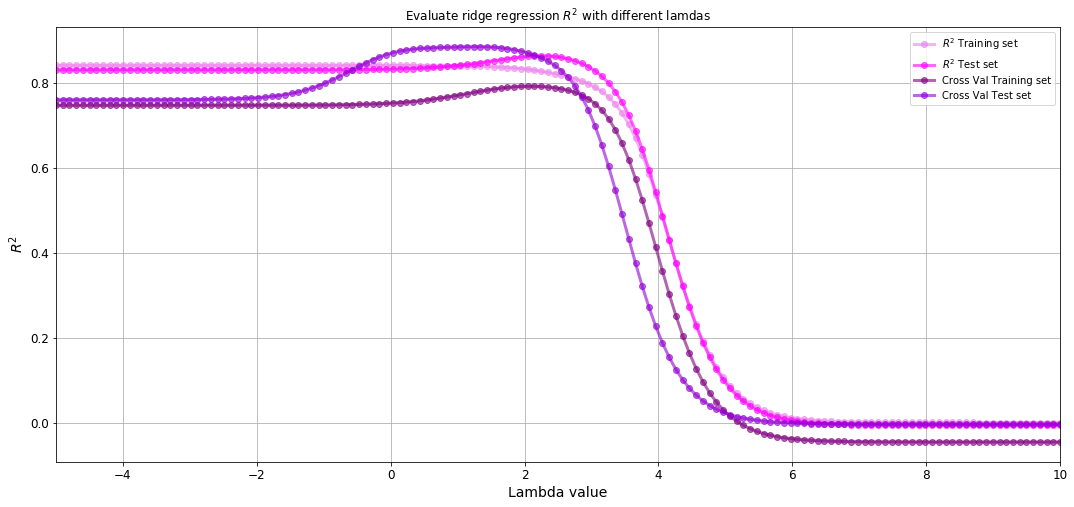

In [12]:
# Plotting
plt.figure(figsize=(18, 8))

plt.plot(lambdas, train_r_squared, 'bo-', label=r'$R^2$ Training set', color="violet", alpha=0.6, linewidth=3)
plt.plot(lambdas, test_r_squared, 'bo-', label=r'$R^2$ Test set', color="magenta", alpha=0.6, linewidth=3)

plt.plot(lambdas, train_crossVal, 'bo-', label=r'Cross Val Training set', color="purple", alpha=0.6, linewidth=3)
plt.plot(lambdas, test_crossVal, 'bo-', label=r'Cross Val Test set', color="darkviolet", alpha=0.6, linewidth=3)


plt.xlabel('Lambda value'); plt.ylabel(r'$R^2$')
plt.xlim(lambda_min, lambda_max)
plt.title(r'Evaluate ridge regression $R^2$ with different lamdas')
plt.legend(loc='best')
plt.grid()

In [13]:
max_r2_index = np.argmax(test_r_squared)
print("Max R^2 value in the testing set: R^2 = {0:} for alpha = 10^({1:})".format(test_r_squared[max_r2_index], max_r2_index / eta + lambda_min ))  

max_CV_index = np.argmax(test_crossVal)
print("Max R^2 value in the testing set: average cross_val = {0:} for alpha = 10^({1:})".format(test_crossVal[max_CV_index], max_CV_index / eta +lambda_min))  


Max R^2 value in the testing set: R^2 = 0.8637009101853824 for alpha = 10^(2.2)
Max R^2 value in the testing set: average cross_val = 0.8852807434179489 for alpha = 10^(1.2000000000000002)


## Simple Linear Regression

In [14]:
# First, let's do plain OLS
reg = Lin_Reg()
reg.fit(x_train, y_train)
coefficients = reg.coef_
coeff.append(coefficients)

predictors = [i for i, item in enumerate(coefficients) if abs(item) > 0]

print('Simple Linear Regression')
print('\nCoefficients: {:}'.format(coefficients))
print('\nSelected predictors:{:}'.format(predictors))
print('\nRidge Regression: R^2 score on training set:\t{:}'.format(reg.score(x_train,y_train)))
print('Ridge Regression: R^2 score on test set:\t{:}'.format(reg.score(x_test,y_test)))
print('\nAverage Cross Validation in training set:\t{:}'.format(np.average(cross_val_score(reg,x_train, y_train, scoring ='r2',cv = 5))))
print('Average Cross Validation in test set:\t{:}'.format(np.average(cross_val_score(reg,x_test, y_test, scoring ='r2',cv = 5))))


Simple Linear Regression

Coefficients: [-0.28061462  0.05104857 -0.15460989 -0.04297544  0.44098665  0.005491
  0.13869646  0.00513993  0.06168441  0.01019921  0.05313596  0.19770215
  0.96022942 -0.15189512  0.15189512  0.02761406 -0.02761406 -0.1320875
  0.1320875  -0.15358572  0.15358572  0.09139646 -0.09139646  1.03137886
  0.1976473  -0.52810796 -0.37271117 -0.32820704  0.22763397  0.11986357
 -0.41357246  0.29436687 -0.22829194 -0.19158963  0.07314733 -0.0189213
  0.11068298  0.02668062 -0.22275652  0.2497752   0.12972998 -0.21519208
  0.05844343 -0.13960757 -0.2412962   0.32870636  0.0521974  -0.1978384
  0.08236484  0.11547356 -0.14350801  0.14350801  0.03089716 -0.03089716
  0.01037318 -0.01037318  0.07313673 -0.07313673  0.22218918 -0.22218918
 -0.30202401  0.30202401  0.32403583 -0.32403583  0.02612398 -0.02612398]

Selected predictors:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 3

In [15]:
coeff = pd.DataFrame(coeff).T
coeff.columns = ['Ridg, alpha = 1', 'Ridge, best alpha', 'linear regression']
coeff

,"Ridg, alpha = 1","Ridge, best alpha",linear regression
0,-0.276707,-0.179469,-0.280615
1,0.054406,0.029149,0.051049
2,-0.151408,-0.092727,-0.154610
3,-0.036431,-0.035476,-0.042975
4,0.431025,0.237209,0.440987
5,0.006470,0.011646,0.005491
6,0.133377,0.080852,0.138696
7,-0.002334,-0.013033,0.005140
8,0.067623,0.054496,0.061684
9,0.016387,0.025599,0.010199


## Comment on the results

The given dataset was cleaned form NaN values, all categorical features were transformed into a dummy ones.
Three models were made based on 66 features and 365 observations in the giver dataset. The results are shown below (teraining set / test set: 0.75 / 0.25 )

###  Results:

#### Ridge Regression, $\alpha = 1$
* Ridge Regression: R^2 score on training set:	__0.8408768443402062__
* Ridge Regression: R^2 score on test set:	__0.8329289822203993__
* Average Cross Validation in training set:	__0.7797846587382491__
* Average Cross Validation in test set:	__0.8558614867998596__

#### Ridge Regression, $\alpha = 158$
* idge Regression: R^2 score on training set: __0.82857433047376__
* Ridge Regression: R^2 score on test set:	__0.8635977324793842__
* Average Cross Validation in training set:	__0.8062878034930838__
* Average Cross Validation in test set:	__0.84697939112969__

#### Linear Regression
* Ridge Regression: R^2 score on training set:	__0.841131880112827__
* Ridge Regression: R^2 score on test set:	__0.8307676871934955__
* Average Cross Validation in training set:	__0.7749440784576876__
* Average Cross Validation in test set:	__0.815189516353987__


Ridge regression with the alpha parameter equal to $\alpha=158$ gives better results for testing set than linear regression. For $\alpha=1$ the ridge model gives slightly better results for the test set for cross validation tests. Based on the plot - for $\alpha<10^2$ the RSS part (in the ridge regression model) outweighs the $\alpha$-part (high variance of the model). For $\alpha > 10^4$ the model gives almost the same results, doesn't matter which data subset was given to fit (Lov variance).
